# RESNET

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, ZeroPadding2D, BatchNormalization, Activation, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [3]:
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
training_set=train_datagen.flow_from_directory('dataset/train',target_size=(200,200),batch_size=32,class_mode='categorical')

Found 1329 images belonging to 3 classes.


In [4]:
test_datagen=ImageDataGenerator(rescale=1./255) 
test_set=test_datagen.flow_from_directory('dataset/Test',target_size=(200,200),batch_size=32,class_mode='categorical')

Found 187 images belonging to 3 classes.


In [5]:
def identity_block(X, f, filters):
    # Retrieve Filters
    F1, F2, F3 = filters

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    return X

In [6]:
def convolutional_block(X, f, filters, s): 
    # Retrieve Filters
    F1, F2, F3 = filters

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    return X

In [7]:
def ResNet50(input_shape, classes):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 3)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL.
    X = AveragePooling2D((2, 2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [8]:
model = ResNet50(input_shape = (200, 200, 3), classes = 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 206, 206, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 100, 100, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 64)       0     

                                                                 
 batch_normalization_16 (Bat  (None, 17, 17, 128)      512       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 17, 17, 128)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 17, 17, 128)       147584    
                                                                 
 batch_normalization_17 (Bat  (None, 17, 17, 128)      512       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 17, 17, 128)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 17, 17, 512)       66048     
                                                                 
 batch_nor

 conv2d_34 (Conv2D)          (None, 9, 9, 256)         262400    
                                                                 
 batch_normalization_34 (Bat  (None, 9, 9, 256)        1024      
 chNormalization)                                                
                                                                 
 activation_34 (Activation)  (None, 9, 9, 256)         0         
                                                                 
 conv2d_35 (Conv2D)          (None, 9, 9, 256)         590080    
                                                                 
 batch_normalization_35 (Bat  (None, 9, 9, 256)        1024      
 chNormalization)                                                
                                                                 
 activation_35 (Activation)  (None, 9, 9, 256)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 9, 9, 1024)        263168    
          

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
mc = ModelCheckpoint('resnet.h5', monitor = 'accuracy', verbose=1, save_best_only = True)

In [14]:
batch_size = 64
epochs = 30

#### Fitting the model
history = model.fit_generator(
           training_set, steps_per_epoch=training_set.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_set,validation_steps=test_set.samples // batch_size,
           callbacks=[mc])

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.9289 - accuracy: 0.5281
Epoch 1: accuracy improved from 0.51562 to 0.52812, saving model to resnet.h5
20/20 [==============================] - 67s 3s/step - loss: 0.9289 - accuracy: 0.5281 - val_loss: 1.1405 - val_accuracy: 0.1676
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.9255 - accuracy: 0.5328
Epoch 2: accuracy improved from 0.52812 to 0.53281, saving model to resnet.h5
20/20 [==============================] - 67s 3s/step - loss: 0.9255 - accuracy: 0.5328 - val_loss: 1.4972 - val_accuracy: 0.1420
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.7960 - accuracy: 0.6500
Epoch 3: accuracy improved from 0.53281 to 0.65000, saving model to resnet.h5
20/20 [==============================] - 68s 3s/step - loss: 0.7960 - accuracy: 0.6500 - val_loss: 1.3646 - val_accuracy: 0.5057
Epoch 4/30
20/20 [==============================] - ETA: 0s - loss: 0.7732 - accuracy: 0.6469
Epo

20/20 [==============================] - 69s 3s/step - loss: 0.2271 - accuracy: 0.9264 - val_loss: 2.1197 - val_accuracy: 0.3040
Epoch 30/30
20/20 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.9141
Epoch 30: accuracy did not improve from 0.93437
20/20 [==============================] - 77s 4s/step - loss: 0.2655 - accuracy: 0.9141 - val_loss: 2.4227 - val_accuracy: 0.3068


In [15]:
def graph():
    #Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

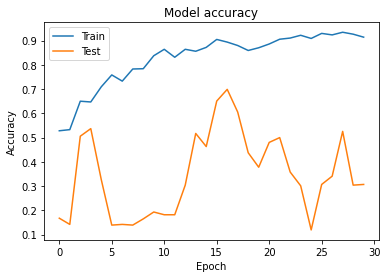

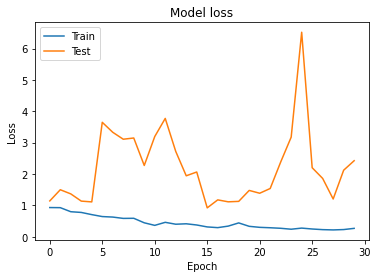

In [16]:
graph()